In [8]:
from qiskit import *
from qiskit import Aer, transpile, execute, assemble
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector
from qiskit_ibm_provider import IBMProvider
from qiskit.visualization import plot_state_city
from qiskit.providers.aer import AerSimulator
from qiskit.result import marginal_counts
from qiskit.circuit import IfElseOp
import random
import numpy as np
from IPython.display import display

Public Key (pk): 2
Secret Key (sk): 17


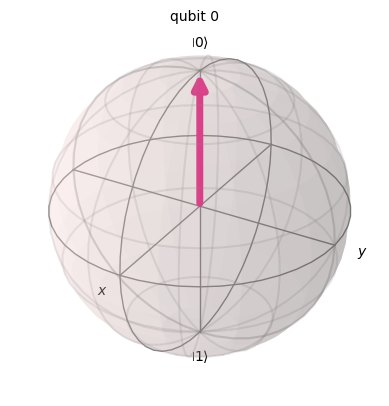

In [9]:
def QHE_KeyGen(security_parameter):
    # for demonstrate purpose, generating classical keys based on the length of the security
    pk = random.randint(1, 2 * len(security_parameter))
    sk = random.randint(1, 2 * len(security_parameter))
    
    #Quantum evaluation key
    #Again, for simplicity, let's just generate a single qubit quantum state.
    #but in actual QHE, this could be a more complex state. 
    rho_evk = QuantumCircuit(1)
    if random.choice([True, False]):
        rho_evk.h(0)
    if random.choice([True, False]):
        rho_evk.z(0)
    
    return pk, sk, rho_evk, 

#Testing the function 
security_parameter = "1111111111" #for k=10
pk, sk, rho_evk = QHE_KeyGen(security_parameter)
print(f"Public Key (pk): {pk}")
print(f"Secret Key (sk): {sk}")
rho_evk.draw('mpl')

#Add measurements to your circuit
rho_evk.measure_all()

#Assuming 'rho_evk' is your Quantum Circuit without measurement 
simulator = Aer.get_backend('statevector_simulator')
#simulator = Aer.get_backend('qasm_simulator')


# Transpile the Circuit
rho_evk_transpiled = transpile(rho_evk, simulator)

# Run the Simulation
result = simulator.run(rho_evk_transpiled).result()
#result = execute(rho_evk_transpiled, simulator, shots=1024).result()

# Get the Statevector and Plot on Bloch Sphere
statevector = result.get_statevector()
plot_bloch_multivector(statevector)
    

Probabilities for Circuit 1 representing state |00⟩:


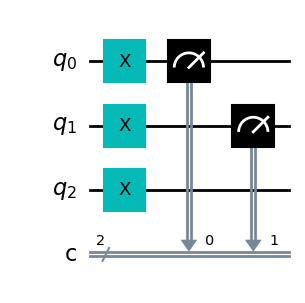

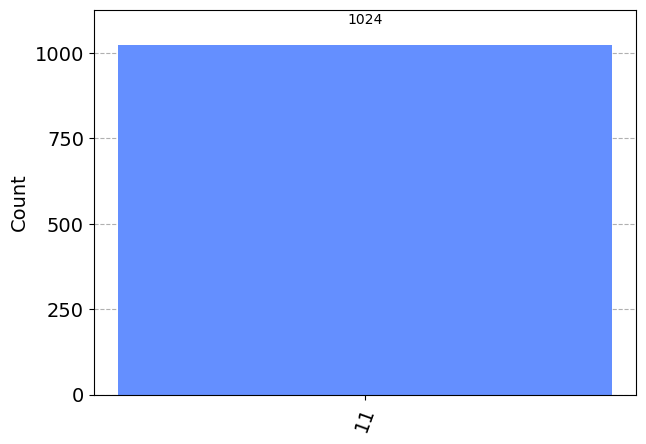




Probabilities for Circuit 2 representing state |01⟩:


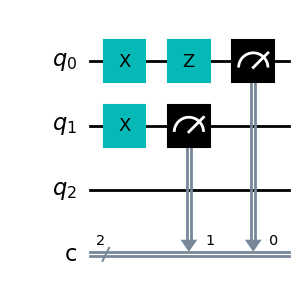

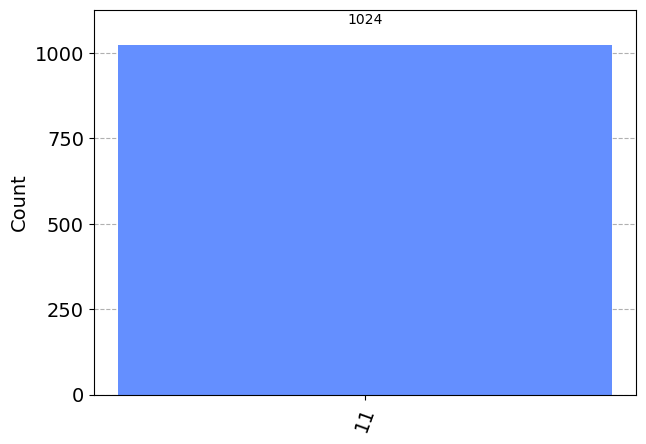




Probabilities for Circuit 3 representing state |10⟩:


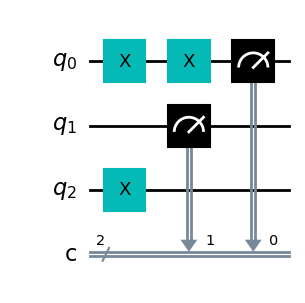

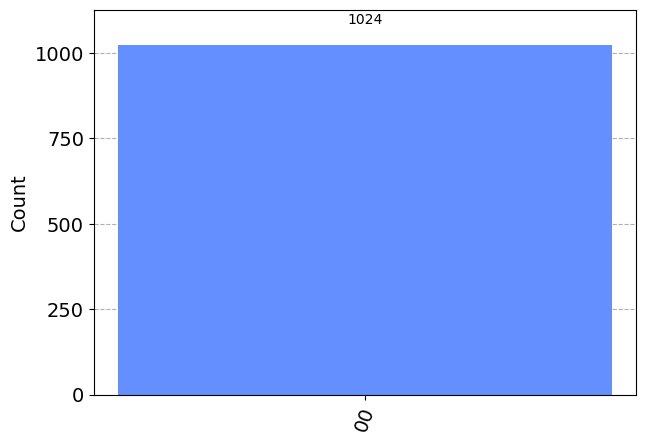




Probabilities for Circuit 4 representing state |11⟩:


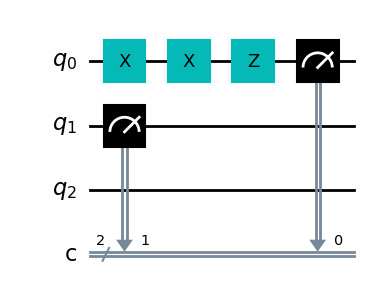

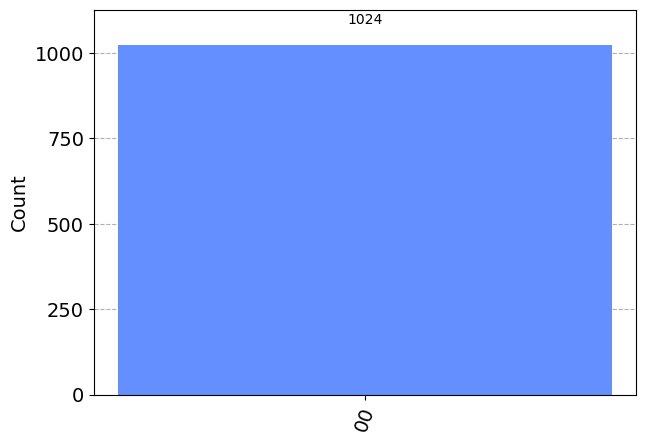

In [13]:
#Mock HE functions 
def HE_Enc(pk, bit):
    return pk ^ bit #just for illustrative purpose

def HE_Dec(sk, encrypted_bit):
    return encrypted_bit ^ sk

#Quantum One-Time Pad Encryption 
def QEnc(a, b, qubit):
    if a:
        qubit.x(0)
    if b: 
        qubit.z(0)
    return qubit 

def CL_Enc(pk):
    circuits = []
    #create a 3-qubit QuantumCircuit. 1st qubit is the message qubit. 
    #2nd and 3rd qubits are for storing encrypted classical bits
    for a in [0, 1]:
        for b in [0, 1]:
            qc = QuantumCircuit(3, 2)
            # Set the first qubit as message qubit (assuming |1> as the message for this state)
            qc.x(0)
            # Encrypte the message qubit using Quantum One-Time Pad
            qc = QEnc(a, b, qc)
            
            #Stroing the encrypted classical bits (HE.Encpk) into the 2nd and 3rd qubits. 
            encrypted_a = HE_Enc(pk, a)
            encrypted_b = HE_Enc(pk, b)
            
            if encrypted_a:
                qc.x(1)
            if encrypted_b:
                qc.x(2)
            circuits.append(qc)
    return circuits, 

pk = 1 #Example public key 
encrypted_circuits = CL_Enc(pk)

#Assuming you have states you want to name your circuits after. 
#For instance: 
states = ["|00⟩", "|01⟩", "|10⟩", "|11⟩"]  # or whatever states you're aiming for

#Iterate over the encrypted circuits and draw each one. 
for idx, circuits in enumerate(encrypted_circuits[0]):
    #Adding a measurement on all qubits. 
    circuits.measure([0, 1], [0, 1])
    #Measurement on all three qubits. 
    
    #Use Aer's qasm_simulator
    backend_sim = Aer.get_backend('qasm_simulator')
    #Execute the circuit on the qasm simulator.We've set the number of repeats of the circuit
    # to be 1024, which is the default.
    job_sim = backend_sim.run(transpile(circuits, backend_sim), shots=1024)

    # Grab the results from the job.
    result_sim = job_sim.result()

    # aggregated binary outcome
    counts = result_sim.get_counts(circuits)

    #view the outome
    plot_histogram(counts)
    

    # Getting and plotting the results
    print(f"Probabilities for Circuit {idx+1} representing state {states[idx]}:")
    # Setting the name of the quantum circuit to the state
    #title = f"Circuit {idx+1} representing state {states[idx]}"
    #print(title)  # Printing the title
    display(circuits.draw('mpl'))  # Using display to show circuits one after another in Jupyter
    display(plot_histogram(counts))
    print("\n\n")  # Some spacing between circuits


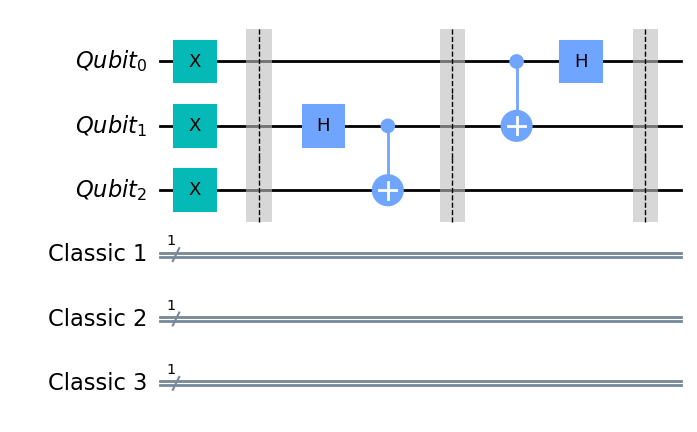

In [14]:
def create_bell_pair(teleportation_circuit, a, b):
    """Create a Bell pair (entangled pair) using a quantum circuit."""
    teleportation_circuit.h(a)
    teleportation_circuit.cx(a,b)
    return teleportation_circuit
    
def alice_teleportation(teleportation_circuit, psi, a):
    """Applies the gates required by Alice before sending her qubit"""
    teleportation_circuit.cx(psi, a)
    teleportation_circuit.h(psi)

def bob_teleportation(teleportation_circuit, qubit, a, b):
    """Applies the gates required by Bob after receiving Alice's qubit"""
    if b == 1:
        teleportation_circuit.z(qubit)
    if a == 1:
        teleportation_circuit.x(qubit)
    
def teleportation_with_encryption(pk, sk, a, b):
    # Create main quantum circuit
    qr = QuantumRegister (3, name="Qubit")#protocol use 3 qubits 
    crz = ClassicalRegister(1, name="Classic 1")#2 classical bits 
    crx = ClassicalRegister(1, name="Classic 2") # in 2 different registers
    #crb = ClassicalRegister(1, name="Classic 3") # the thrid register to measruing Bob result
    teleportation_circuit = QuantumCircuit(qr, crz, crx)

    # Encrypt and prepare Alice's qubit to teleport (qubit 0) - Assuming the state |1> as example
    #teleportation_circuit.x(0)
    encrypted_circuit = CL_Enc(pk)[0]
    teleportation_circuit.compose(encrypted_circuit[0], [0, 1, 2], inplace=True)
    teleportation_circuit.barrier() 

    #Step 1 of teleportation : Prepare the entangled Bell pair (qubits 1 and 2)
    
    create_bell_pair(teleportation_circuit, 1, 2)
    
    #Step 2 of teleportation : Perform Alice's part of teleportation
    teleportation_circuit.barrier() 
    alice_teleportation(teleportation_circuit, 0, 1)

    #Step 3 : Measure Alice's qubits
    #teleportation_circuit.measure(0, crz[0])
    #teleportation_circuit.measure(1, crx[0])
    teleportation_circuit.barrier()
    
    # step4 of quantum teleportation: Perform Bob's part of teleportation
    bob_teleportation(teleportation_circuit, 2, a, b)
    
    # Add a classical register for measuring the teleportation outcome
    crb = ClassicalRegister(1, name="Classic 3")
    teleportation_circuit.add_register(crb)
    #teleportation_circuit.measure(2, crb[0])
    
    return teleportation_circuit
    #return result.get_counts()

pk = 1  # Example public key
sk = 1 # Example secret key
a = 0 # example value 
b = 0 # example value 
#print(teleportation_with_encryption(pk, sk, a, b))

# Generate the teleportation + encryption circuit
teleportation_encryption_circuit = teleportation_with_encryption(pk, sk, a, b)

# Draw the circuit
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.We've set the number of repeats of the circuit
# to be 1024, which is the default.
#job_sim = backend_sim.run(transpile(teleportation_encryption_circuit, backend_sim), shots=1024)

# Grab the results from the job.
#result_sim = job_sim.result()

# aggregated binary outcome
#counts = result_sim.get_counts(teleportation_encryption_circuit)

#view the outome
plot_histogram(counts)

# Get the marginal counts for qubit 2
#Qubit_2 = 2
#Qubit_counts = marginal_counts(counts, [Qubit_2])

# Plot the histogram for qubit 2
#plot_histogram(Qubit_counts)
display(teleportation_encryption_circuit.draw('mpl'))  # Using display to show circuits one after another in Jupyter
#display(plot_histogram(counts))
#print(f"The experimental error rate : {Qubit_counts['1']*100/sum(Qubit_counts.values()):.3f}%")

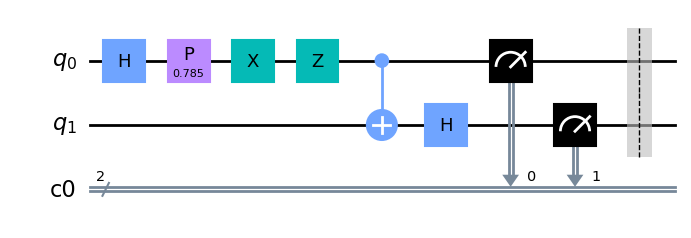

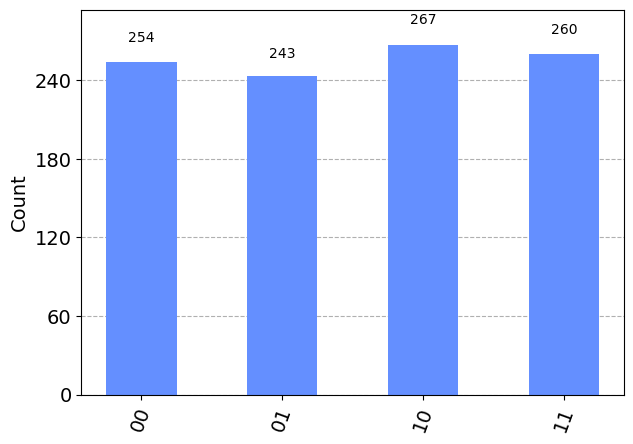

In [15]:
def homomorphic_evaluation(qc: QuantumCircuit, gate_sequence: list, encrypted_keys: list) -> (QuantumCircuit, dict):
    
    # Key-polynomials initialization
    num_qubits = qc.num_qubits
    fa = ['a{}'.format(i) for i in range(num_qubits)]
    fb = ['b{}'.format(i) for i in range(num_qubits)]

    # Traverse the gate sequence and apply to the quantum circuit
    for gate in gate_sequence:
        gate_type = gate[0]
        
        if gate_type == 'H':
            qc.h(gate[1][0])
            fa[gate[1][0]] = 'a{} XOR b{}'.format(gate[1][0], gate[1][0])
            fb[gate[1][0]] = 'a{}'.format(gate[1][0])

        elif gate_type == 'P':
            qc.p(3.1415/4, gate[1][0])
            # Update fa and fb (This would depend on your specific encryption scheme)
            
        elif gate_type == 'X':
            qc.x(gate[1][0])
            fa[gate[1][0]] = 'NOT(a{})'.format(gate[1][0])
            fb[gate[1][0]] = 'NOT(b{})'.format(gate[1][0])

        elif gate_type == 'Z':
            qc.z(gate[1][0])
            fa[gate[1][0]] = '-a{}'.format(gate[1][0])
            fb[gate[1][0]] = '-b{}'.format(gate[1][0])        
        elif gate_type == 'CNOT':
            if gate[1][1] < len(fa): 
                qc.cx(gate[1][0], gate[1][1])
                fa[gate[1][1]] = 'a{} XOR a{}'.format(gate[1][1], gate[1][0])
                fb[gate[1][1]] = 'b{} XOR a{}'.format(gate[1][1], gate[1][0])
            else:
                print("Index out of range!")
                return None
    
    # Here, you'd use the fa and fb to homomorphically evaluate on the encrypted classical keys 
    key_polynomials = {
        'fa': fa,
        'fb': fb
    }
    
    qc.add_register(ClassicalRegister(2))
    qc.measure([0, 1], [0, 1])
    qc.barrier()

    return qc, key_polynomials

# Define the sequence of Clifford gates for demonstration
clifford_gates_sequence = [
    ('H', [0]), 
    ('P', [0]),
    ('X', [0]),
    ('Z', [0]),
    ('CNOT', [0, 1]),
    ('H', [1])
]

# For demonstration, I'm using a placeholder function for teleportation_with_encryption.
# Replace this with your actual function.
def teleportation_with_encryption(pk, sk, a, b):
    return QuantumCircuit(2)

# Mocking some variables
pk, sk, a, b = 1, 1, 0, 0  # Replace these with actual values

# Execute the protocol
teleportation_qc = teleportation_with_encryption(pk, sk, a, b)
new_qc, updated_keys = homomorphic_evaluation(teleportation_qc, clifford_gates_sequence, [sk, pk])

# The rest of your code for simulation and getting the results would go here.


# Display the circuit
# Draw the circuit
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = backend_sim.run(transpile(new_qc, backend_sim), shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()

# aggregated binary outcome
counts = result_sim.get_counts(new_qc)

#view the outome
plot_histogram(counts)
#teleportation_encryption_circuit.draw('mpl')  # 'mpl' specifies the matplotlib-based drawing
display(new_qc.draw('mpl'))  # Using display to show circuits one after another in Jupyter
display(plot_histogram(counts))

Inside function, before return: <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>
After function call: <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>


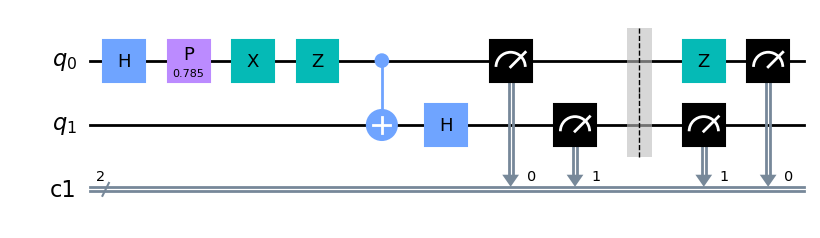

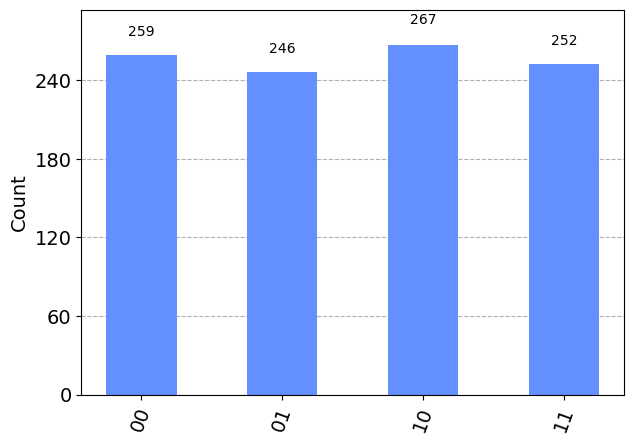

In [16]:
def append_decryption_to_circuit(qc, sk, mock_result):

    
    # Decode classical registers from the measurement result
    a_encrypted_value = int(mock_result[0])  # Assuming results are strings of '0's and '1's
    b_encrypted_value = int(mock_result[1])
    
    a = HE_Dec(sk, a_encrypted_value)
    b = HE_Dec(sk, b_encrypted_value)
    
    
    #Use QDec function for decrypting the quantum data 
    QDec(a, b, qc)
    
    #qc.add_register(ClassicalRegister(2))  # Adding classical bits
    qc.measure([0, 1], [0, 1])
    
    print("Inside function, before return:", type(qc))
    return qc

def HE_Dec(sk, encrypted_bit):
    """Homomorphic Decryption - An example, might not be secure."""
    return encrypted_bit ^ sk

def QDec(a, b, qubit):
    """Quantum One-Time Pad Decryption (inverse of QEnc)."""
    if b:
        qubit.z(0)
    if a:
        qubit.x(0)
         

#Workflow 

# 1. Key Generation
pk = 1  # Example public key
sk = 1  # Example secret key

# 2. Encryption
encrypted_circuits = CL_Enc(pk)

# Assume you're using the first encrypted circuit for the sake of demonstration
encrypted_circuit = encrypted_circuits[0][0]

# 3. Teleportation with Encryption
teleportation_circuit = teleportation_with_encryption(pk, sk, a, b)

# 4. Homomorphic Evaluation
# For this, let's assume a simple gate sequence to demonstrate
# Define the sequence of Clifford gates for demonstration
clifford_gates_sequence = [
    ('H', [0]), 
    ('P', [0]),
    ('X', [0]),
    ('Z', [0]),
    ('CNOT', [0, 1]),
    ('H', [1])
]
evaluated_circuit, _ = homomorphic_evaluation(teleportation_circuit, clifford_gates_sequence, [sk, pk])

# Simulate a measurement result for testing (replace this with actual result when needed)
mock_result = ['1', '0']

# 5. Decryption
# Simulate a measurement result for testing (replace this with an actual result when needed)
decryption_circuit = append_decryption_to_circuit(evaluated_circuit, sk, mock_result)
print("After function call:", type(decryption_circuit))
mock_result = ['1', '0']


# Draw the circuit
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = backend_sim.run(transpile(decryption_circuit, backend_sim), shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()

# aggregated binary outcome
counts = result_sim.get_counts(decryption_circuit)

#view the outome
plot_histogram(counts)
#teleportation_encryption_circuit.draw('mpl')  # 'mpl' specifies the matplotlib-based drawing
display(decryption_circuit.draw('mpl'))  # Using display to show circuits one after another in Jupyter
display(plot_histogram(counts))